In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
sns.set()

import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions import Normal

### Setup

Define model as follows:
\begin{equation}
    y = a f_{\theta}(x) + b \qquad t = y + \sigma \epsilon \qquad \epsilon \sim \mathcal{N}(0, 1)
\end{equation}
with $a,b$ parameters with uniform Gaussian priors, $f_{\theta}$ a deterministic function, $t$ observations subject to random noise.

We might be interested in:
 - Predictive distribution $p_{\theta} (t\ |\ x) = \int_{a,b} \mathcal{N}(t\ |\ a f_{\theta}(x) + b, \sigma^2) \mathcal{N}(a\ |\ 0,1) \mathcal{N}(b\ |\ 0,1) \ da\ db$
 - Posterior inference $p_{\theta} (a, b\ |\ t, x) = \dfrac{p_{\theta} (t\ |\ a, b, x) p(a, b)}{p_{\theta} (t\ |\ x)}$, where denominator is intractable but necessary because it's a function of $\theta$.
 - ML (or MAP) estimate of $\theta$ to maximize $p_{\theta}(t | x)$
 
Approximate prior $p(a,b)$ with mean field variational distribution $q(a,b) = q(a)q(b)$. Then we can bound the predictive distribution given $\theta$ (marginal likelihood) as follows:
\begin{equation}
    p_{\theta} (t\ |\ x) \geq \mathcal{L} = \mathbb{E}_q[\log p_{\theta}(t\ |\ a, b, x)] - \mathrm{KL}(q(a,b) \ ||\ p(a,b))
\end{equation}
with
\begin{split}
\mathbb{E}_q[\log p_{\theta}(t\ |\ a, b, x)] = -\frac{1}{2} \log \sigma^2 - \frac{1}{2\sigma^2} \mathbb{E}_q[(t - a f_{\theta}(x) - b)^2] + \mathrm{const.}\\
\mathrm{KL}(q(a,b) \ ||\ p(a,b)) = -\frac{1}{2} \sum_{i\in\{a,b\}} \left(1 + \log \sigma_i^2 - \mu_i^2 - \sigma_i^2\right)
\end{split}
We can compute analytically all terms except for the expected value which is MSE and we estimate by sampling as usual.

#### Toy Dataset 1

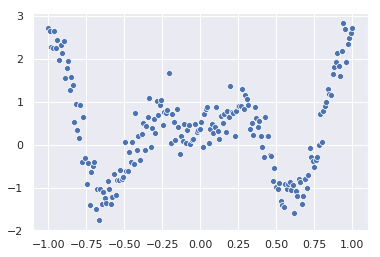

In [2]:
N = 200
a = 0.5
b = 0.2
scale = 0.3
x = np.linspace(-1, 1, N).reshape(-1, 1)
fx = x * 5 * np.sin(8 * x)
t = a*fx + b + scale*np.random.randn(*x.shape)
sns.scatterplot(x[:, 0], t[:, 0])
plt.show() 

x = torch.tensor(x, dtype=torch.float)
t = torch.tensor(t, dtype=torch.float)

#### Features extractor and stochastic layer

Define function $f_{\theta}$ to extract features $h = f_{\theta}(x)$, with parameters $\theta$ to be optimized.

The stochastic layer has no state, it's only used to get samples $\nu \sim \mathcal{N}(\mu, \sigma^2)$, and to compute the KL divergence from a prior $\mathcal{N}(0, 1)$ to a variational distribution $q = \mathcal{N}(\mu, \sigma^2)$.

In [3]:
class FeaturesExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 1))
        
    def forward(self, x):
        return self.layers(x)
    
    
class StochasticLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu_q, logvar_q):
        eps = torch.randn_like(mu_q)
        std = (logvar_q/2).exp()
        return mu_q + std * eps

    def get_kl(self, mu_q, logvar_q):
        assert mu_q.dim() == 2
        batch_size = mu_q.size(0)
        kl = -0.5 * (1 + logvar_q - mu_q.pow(2) - logvar_q.exp())
        return kl.sum(1)  # now it's [1, 2], and we sum over variables


### Optimize

Here we maximize the ELBO $\mathcal{L}$ with respect to variational parameters $\mu_a, \sigma_a, \mu_b, \sigma_b$, the NN parameters $\theta$, and the noise variance $\sigma$.

NOTE: now KL is not actually optimized!

In [4]:
features = FeaturesExtractor()
stochastic = StochasticLayer()
l_rate = 0.01
epochs = 2000
n_samples = 50
mu_ab = nn.Parameter(torch.tensor([[0., 0.]]))  # for a and b
logvar_ab = nn.Parameter(torch.tensor([[0., 0.]]))  # for a and b
logvar = nn.Parameter(torch.tensor(0.))  # for noise
optimiser = torch.optim.Adam(list(features.parameters()) + [mu_ab, logvar_ab, logvar], lr = l_rate)

for epoch in range(epochs):
    optimiser.zero_grad()
    h = features(x)
    kl = stochastic.get_kl(mu_ab, logvar_ab)
    expected_mse = 0.
    for i in range(n_samples):
        ab_samples = stochastic(mu_ab, logvar_ab)
        a, b = ab_samples.chunk(2, dim=1)
        y = a * h + b
        expected_mse += (t - a * h - b)**2
    expected_mse /= n_samples
    recons = 0.5/logvar.exp() * expected_mse + 0.5*logvar
    loss = recons #+ kl
    loss = loss.mean()
    loss.backward()
    optimiser.step()
    if epoch % 250 == 0:
        print('epoch {}, loss {:.4g}, recons {:.4g}, KL {:.4g}'.format(epoch, loss, recons.mean(), kl.mean()))

epoch 0, loss 1.174, recons 1.174, KL 0
epoch 250, loss -0.003824, recons -0.003824, KL 3.402
epoch 500, loss -0.4334, recons -0.4334, KL 6.079
epoch 750, loss -0.5595, recons -0.5595, KL 7.451
epoch 1000, loss -0.5897, recons -0.5897, KL 8.236
epoch 1250, loss -0.5918, recons -0.5918, KL 8.805
epoch 1500, loss -0.6306, recons -0.6306, KL 9.387
epoch 1750, loss -0.6328, recons -0.6328, KL 9.798


### Visualization

First we sample $a,b \sim q(a,b)$ according to the learned variational parameters. Get $N$ samples $a_i$ and $b_i$. Then sample from predictive distribution
$$t_i = a_i f_{\theta}(x_i) + b_i + \sigma \epsilon_i$$
with $\epsilon_i$ iid samples from $\mathcal{N}(0,1)$.

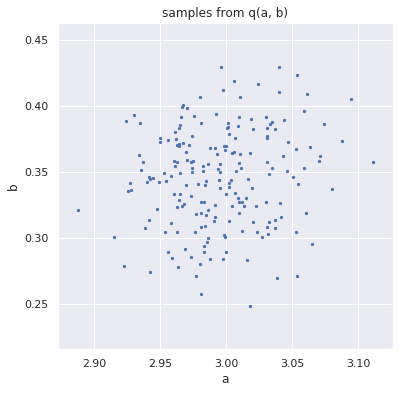

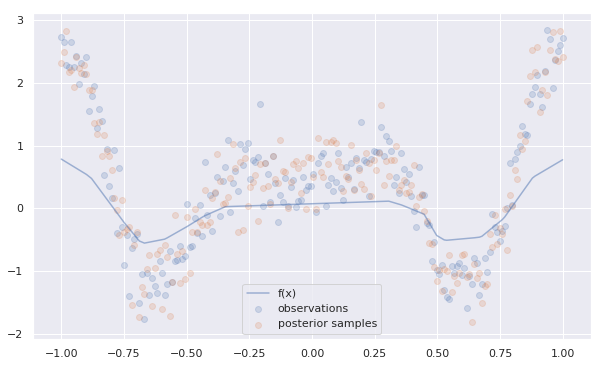

In [5]:
# Get parameters of q(a) and q(b)
mu_a = mu_ab[0, 0].detach().numpy()
mu_b = mu_ab[0, 1].detach().numpy()
std_a = (logvar_ab[0, 0]/2).exp().detach().numpy()
std_b = (logvar_ab[0, 1]/2).exp().detach().numpy()

# Sample a, b ~ q(a, b) and show
n_samples = t.shape[0]
a = np.random.randn(n_samples) * std_a + mu_a
b = np.random.randn(n_samples) * std_b + mu_b
plt.figure(figsize=(6, 6))
plt.pcolor
plt.scatter(a, b, s=5)
plt.xlabel('a')
plt.ylabel('b')
plt.title('samples from q(a, b)')
plt.gca().set_aspect('equal', 'datalim')  # equal aspect ratio
plt.show()

# For each x_i, use samples a_i, b_i to compute predicted t_i
h = features(x).squeeze().detach().numpy()
post_samples = a * h + b + (logvar/2).exp().detach().numpy() * np.random.randn(*a.shape)
plt.figure(figsize=(10,6))
plt.scatter(x, t, alpha=0.2, label='observations')
plt.scatter(x, post_samples, alpha=0.2, label='posterior samples')
plt.plot(x.numpy(), h, alpha=0.5, label='f(x)')
# plt.plot(x.numpy(), p5.numpy(), '--', color=sns.color_palette()[1], label='95% posterior interval')
# plt.plot(x.numpy(), p95.numpy(), '--',color=sns.color_palette()[1])
plt.legend()
plt.show()

In [6]:
print('a: N({:.3g}, {:.3g})'.format(mu_ab[0, 0], logvar_ab[0, 0].exp()))
print('b: N({:.3g}, {:.3g})'.format(mu_ab[0, 1], logvar_ab[0, 1].exp()))
print('noise var: {:.3g} (true value {:.3g})'.format(logvar.exp(), scale**2))

a: N(3, 0.00132)
b: N(0.35, 0.00129)
noise var: 0.102 (true value 0.09)
